This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
!pip uninstall lightgbm -y
!pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 11
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [3]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
train.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'],
      dtype='object')

In [ ]:
train.groupby('point_of_interest')['country'].apply(lambda x: len(set(x))).sort_values()

point_of_interest
P_00000458b5ff8e     1
P_aa9a358d9aa467     1
P_aa9a3b06326f70     1
P_aa9aaa1580a508     1
P_aa9ac06caa6e7d     1
                    ..
P_702695a8571ff6     6
P_30a7ac32c3dff0     7
P_fb339198a31db3     8
P_f82d146eaf21da    15
P_cb260ef030108c    18
Name: country, Length: 739972, dtype: int64

In [ ]:
train[train['point_of_interest'] == 'P_cb260ef030108c']

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
11788,E_02af00674dc81b,suso,40.473145,-3.687787,NaN,NaN,NaN,NaN,KY,NaN,NaN,"Bagel Shops, Gluten-free Restaurants",P_cb260ef030108c
38568,E_08a7389355520d,Embajada,40.473134,-3.687844,NaN,NaN,NaN,NaN,YE,NaN,NaN,Embassies / Consulates,P_cb260ef030108c
56287,E_0c9b5c68a318f6,Telesilla,40.473145,-3.687787,NaN,NaN,NaN,NaN,AL,NaN,NaN,"Bagel Shops, Ski Chairlifts",P_cb260ef030108c
100222,E_1676784eec9f39,Tailandes,40.473376,-3.687722,NaN,NaN,NaN,NaN,UZ,NaN,NaN,"Bagel Shops, Afghan Restaurants",P_cb260ef030108c
107741,E_1827a3004c29ef,pelos,40.473167,-3.687866,NaN,NaN,NaN,NaN,ZW,NaN,NaN,Salons / Barbershops,P_cb260ef030108c
110820,E_18d403ad36a53b,mongo,40.473402,-3.687698,NaN,NaN,NaN,NaN,ES,NaN,NaN,Mongolian Restaurants,P_cb260ef030108c
195735,E_2be946b047deb6,Prensa,40.473248,-3.687801,NaN,NaN,NaN,NaN,GG,NaN,NaN,Newsstands,P_cb260ef030108c
263880,E_3b42722112b3d0,Estornino8,43.451922,-8.329697,El Mar,La Coruña,NaN,NaN,ES,NaN,NaN,Bagel Shops,P_cb260ef030108c
267720,E_3c2013897ef7c0,Guardería,40.473145,-3.687787,NaN,NaN,NaN,NaN,GF,NaN,NaN,"Indian Restaurants, Daycares",P_cb260ef030108c
268587,E_3c51b38878a751,Caribe suso,40.473145,-3.687787,NaN,NaN,NaN,NaN,BH,NaN,NaN,"Bagel Shops, Caribbean Restaurants, Molecular ...",P_cb260ef030108c


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    
    df = df.reset_index(drop=True)
    
    knn = KNeighborsRegressor(n_neighbors=min(len(df), CFG.n_neighbors), 
                              metric='haversine', n_jobs=-1)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']], return_distance=True)
    
    targets = df[CFG.target].values
    for i in range(min(len(df), CFG.n_neighbors)):
        df[f"d_near_{i}"] = dists[:, i]
        df[f"near_target_{i}"] = targets[nears[:, i]]
        for c in columns:
            df[f"near_{c}_{i}"] = df[c].values[nears[:, i]]
    
    for i in range(min(len(df), CFG.n_neighbors), CFG.n_neighbors):
        df[f"d_near_{i}"] = np.nan
        df[f"near_target_{i}"] = np.nan
        for c in columns:
            df[f"near_{c}_{i}"] = np.nan
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_10,near_name_10,near_address_10,near_city_10,near_state_10,near_zip_10,near_country_10,near_url_10,near_phone_10,near_categories_10
0,E_000002eae2a589,carioca manero,-22.907225,-43.178244,nan,nan,nan,nan,br,nan,...,E_24d6cd62bb1ec0,drogarias pacheco,ed. av. central,rio de janeiro,rj,20040-901,br,http://www.drogariaspacheco.com.br,nan,drugstores


# Create Target

In [ ]:
print(CFG.target)

point_of_interest


In [ ]:
for i in range(CFG.n_neighbors):
    train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name_10,near_address_10,near_city_10,near_state_10,near_zip_10,near_country_10,near_url_10,near_phone_10,near_categories_10,target
0,E_000002eae2a589,carioca manero,-22.907225,-43.178244,nan,nan,nan,nan,br,nan,...,drogarias pacheco,ed. av. central,rio de janeiro,rj,20040-901,br,http://www.drogariaspacheco.com.br,nan,drugstores,2.0
1,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,nan,nan,nan,nan,th,nan,...,ร้านตาเอ ปิ่นทองพลาซ่า,nan,nan,nan,nan,th,nan,nan,"boutiques, men's stores",0.0
2,E_000008a8ba4f48,turkcell,37.844510,27.844202,adnan menderes bulvarı,nan,nan,nan,tr,nan,...,bilgin eczanesi,"adnan menderes bulvari,kurtuluş mah.2015 sok.no:2",aydin,aydi̇n,09100,tr,nan,+902562128279,pharmacies,0.0
3,E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,nan,caviedes,cantabria,nan,es,nan,...,clínica yagüez,nan,mayagüez,nan,nan,pr,nan,nan,medical centers,1.0
4,E_000023d8f4be44,island spa,14.518970,121.018702,"5th flr, newport mall, resorts world manila",pasay city,metro manila,nan,ph,nan,...,room 10019,remington hotel,pasay city,nan,nan,ph,nan,nan,hotels,0.0


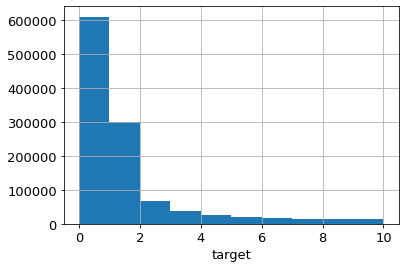

In [ ]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [17]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [16]:
def get_score(input_df: pd.DataFrame):
    scores = []
    precisions = []
    recalls = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
scores = []

train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    idx = train[CFG.target]==train[f"near_target_{i}"]
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]

    score, precision, recall = get_score(train)
    scores.append(score)
train["mathces"] = None

  0%|          | 0/11 [00:00<?, ?it/s]

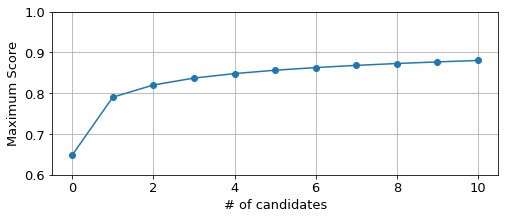

In [ ]:
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
max(scores)

0.8803887594908067

In [ ]:
scores = []

train["matches"] = train["id"]
score, precision, recall = get_score(train)
scores.append(score)
for i in tqdm(range(1, CFG.n_neighbors)):
    idx = train["target"] == i
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]

    score, precision, recall = get_score(train)
    scores.append(score)
train["mathces"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

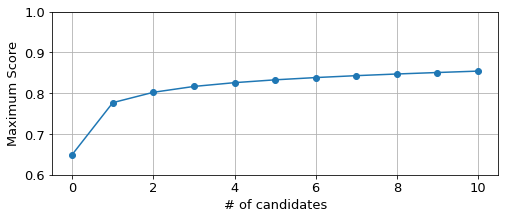

In [ ]:
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
max(scores)

0.8543410220550613

In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [4]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 51.7 MB/s 
     |████████████████████████████████| 103 kB 61.0 MB/s 


In [5]:
%load_ext Cython

In [6]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [7]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss
            
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

In [ ]:
(train['target'] == 0).sum() / len(train)

0.535457125495692

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_10_jaro,near_phone_10_lcs,near_categories_10_gesh,near_categories_10_leven,near_categories_10_jaro,near_categories_10_lcs,near_categories_10_len,near_categories_10_nleven,near_categories_10_nlcsi,near_categories_10_nlcs0
37755,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0.0,0,0.36,25,0.452565,10,17,0.757576,0.588235,0.30303


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_10_jaro,near_phone_10_lcs,near_categories_10_gesh,near_categories_10_leven,near_categories_10_jaro,near_categories_10_lcs,near_categories_10_len,near_categories_10_nleven,near_categories_10_nlcsi,near_categories_10_nlcs0
0,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,nan,nan,nan,nan,my,nan,...,1.0,3,0.25,4,0.511111,1,3,0.8,0.333333,0.2


In [ ]:
if not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [8]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

  0%|          | 0/11 [00:00<?, ?it/s]

['d_near_0', 'near_name_0_gesh', 'near_name_0_jaro', 'near_name_0_lcs', 'near_name_0_len', 'near_name_0_nleven', 'near_name_0_nlcsi', 'near_name_0_nlcs0', 'near_address_0_gesh', 'near_address_0_jaro', 'near_address_0_lcs', 'near_address_0_len', 'near_address_0_nleven', 'near_address_0_nlcsi', 'near_address_0_nlcs0', 'near_city_0_gesh', 'near_city_0_jaro', 'near_city_0_lcs', 'near_city_0_len', 'near_city_0_nleven', 'near_city_0_nlcsi', 'near_city_0_nlcs0', 'near_state_0_gesh', 'near_state_0_jaro', 'near_state_0_lcs', 'near_state_0_len', 'near_state_0_nleven', 'near_state_0_nlcsi', 'near_state_0_nlcs0', 'near_zip_0_gesh', 'near_zip_0_jaro', 'near_zip_0_lcs', 'near_zip_0_leven', 'near_country_0_gesh', 'near_country_0_jaro', 'near_country_0_lcs', 'near_country_0_leven', 'near_url_0_gesh', 'near_url_0_jaro', 'near_url_0_lcs', 'near_url_0_len', 'near_url_0_nleven', 'near_url_0_nlcsi', 'near_url_0_nlcs0', 'near_phone_0_gesh', 'near_phone_0_jaro', 'near_phone_0_lcs', 'near_phone_0_leven', 'nea

In [9]:
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Columns: 619 entries, d_near_0 to near_id_10
dtypes: float16(605), float64(1), object(13)
memory usage: 1.4+ GB


# Split Folds

In [10]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [11]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='logloss',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [12]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=int(train["target"].max() + 1), 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

# Check CV

In [18]:
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
train["matches"] = matches
score, precision, recall = get_score(train)
print(f"CV: {score:.6f}")
print(score, precision, recall)

0it [00:00, ?it/s]

CV: 0.796862
0.7968617658754371 0.9686234426753494 0.8221789479459829


In [19]:
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
test["matches"] = matches

0it [00:00, ?it/s]

# Check Feature Importances

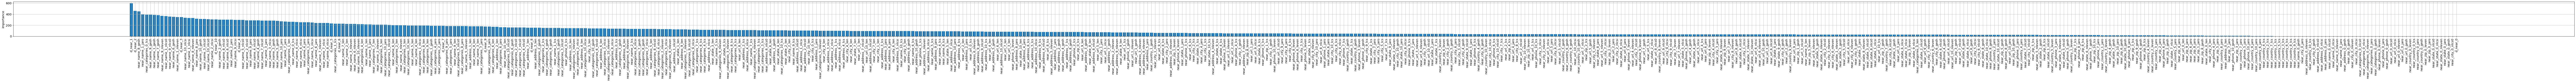

In [20]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [21]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

train = postprocess(train)
test = postprocess(test)
score, precision, recall = get_score(train)
print(f"CV: {score:.6f}")
print(score, precision, recall)

  0%|          | 0/1138812 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CV: 0.805598
0.8055981511118824 0.9582805478462125 0.8406913175752534


# Submit

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
